# Single Noteboook For End-To-End 
- Input Generation
- SA
- Heuristic

#### Importing Necessary Libraries

In [4]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from typing import List, Tuple
from datetime import datetime
import seaborn as sns
from typing import List, Tuple, Dict
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from typing import Dict, List, Any
import warnings

### Section - 1: Input Generation

#### Section - 1.1: Utility Functions

In [5]:
class LocationGenerator:
    def __init__(self, grid_size=100):  # Increased grid size
        self.grid_size = grid_size
        self.depot = np.array([grid_size/2, grid_size/2])
        self.customers = []
        self.charging_stations = []
        
    def calculate_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def is_valid_customer_location(self, new_point):
        depot_dist = self.calculate_distance(new_point, self.depot)
        if not (5 <= depot_dist <= 30):
            return False
            
        for customer in self.customers:
            dist = self.calculate_distance(new_point, customer)
            if dist < 2 or dist > 15:
                return False
        return True
    
    def is_valid_charging_station(self, new_point):
        for station in self.charging_stations:
            dist = self.calculate_distance(new_point, station)
            if dist < 5:  # Reduced minimum distance between stations
                return False
        return True
    
    def generate_locations(self, num_customers, num_stations):
        attempts = 0
        max_attempts = 2000  # Increased max attempts
        
        while len(self.customers) < num_customers and attempts < max_attempts:
            new_point = np.array([
                random.uniform(0, self.grid_size),
                random.uniform(0, self.grid_size)
            ])
            
            if self.is_valid_customer_location(new_point):
                self.customers.append(new_point)
            attempts += 1
            
        if len(self.customers) < num_customers:
            raise ValueError(f"Could not generate {num_customers} valid customer locations")
        customer_array = np.array(self.customers)
        kmeans = KMeans(n_clusters=num_stations, random_state=42)
        kmeans.fit(customer_array)
        initial_positions = kmeans.cluster_centers_
        
        # Refine positions to meet distance constraints
        for position in initial_positions:
            attempts = 0
            while attempts < max_attempts:
                # Add some random noise to the position
                noise = np.random.normal(0, 2, 2)
                new_point = position + noise
                
                # Ensure point is within grid
                new_point = np.clip(new_point, 0, self.grid_size)
                
                if self.is_valid_charging_station(new_point):
                    self.charging_stations.append(new_point)
                    break
                attempts += 1
                
        if len(self.charging_stations) < num_stations:
            raise ValueError(f"Could not generate {num_stations} valid charging stations")
            
        return np.array(self.customers), np.array(self.charging_stations)
    
    def _validate_coverage(self):
        """Validate that coverage requirements are met."""
        # Relaxed validation - ensure basic coverage
        for customer in self.customers:
            has_station = False
            for station in self.charging_stations:
                if self.calculate_distance(customer, station) <= 20:  # Increased coverage radius
                    has_station = True
                    break
            if not has_station:
                return False
        return True

def generate_single_test_case(params: tuple) -> Dict[str, Any]:
    test_case_id, num_customers, num_stations, num_vehicles = params
    
    try:
        generator = LocationGenerator()
        customers, charging_stations = generator.generate_locations(num_customers, num_stations)
        customer_items_weights = np.random.uniform(5, 50, size=num_customers).tolist()
        customer_locations = customers.tolist()
        charging_station_locations = charging_stations.tolist()
        depot_location = generator.depot.tolist()
        test_case = {
            "test_id": test_case_id,
            "depot_location": depot_location,
            "customer_locations": customer_locations,
            "charging_stations": charging_station_locations,
            "num_vehicles": num_vehicles,
            "customer_items_weights": customer_items_weights,
            "vehicle_speed": 25,
            "charging_rate": 22,
            "ev_parameters": {
                "small": {
                    "battery_capacity": 35,
                    "base_weight": 1500,
                    "load_capacity": 500
                },
                "medium": {
                    "battery_capacity": 40,
                    "base_weight": 1800,
                    "load_capacity": 600
                },
                "large": {
                    "battery_capacity": 45,
                    "base_weight": 2000,
                    "load_capacity": 700
                },
                "xlarge": {
                    "battery_capacity": 50,
                    "base_weight": 2200,
                    "load_capacity": 800
                }
            }
        }
        return test_case
    
    except Exception as e:
        warnings.warn(f"Failed to generate test case {test_case_id}: {str(e)}")
        return None

def generate_test_cases(num_test_cases: int,
                       min_customers: int = 10,
                       max_customers: int = 30,
                       min_stations: int = 3,
                       max_stations: int = 8,
                       min_vehicles: int = 2,
                       max_vehicles: int = 6) -> List[Dict[str, Any]]:
    params = []
    for i in range(num_test_cases):
        num_customers = random.randint(min_customers, max_customers)
        num_stations = random.randint(min_stations, max_stations)
        num_vehicles = random.randint(min_vehicles, max_vehicles)
        params.append((i + 1, num_customers, num_stations, num_vehicles))
    num_cores = cpu_count()
    with Pool(num_cores) as pool:
        test_cases = list(tqdm(pool.imap(generate_single_test_case, params),
                             total=num_test_cases,
                             desc="Generating test cases"))
    test_cases = [tc for tc in test_cases if tc is not None]
    
    return test_cases


def save_test_cases(test_cases: List[Dict[str, Any]], output_dir: str = "test_cases"):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    for test_case in test_cases:
        filename = f"{output_dir}/test_case_{test_case['test_id']:03d}_{timestamp}.toml"
        with open(filename, 'w') as f:
            toml.dump(test_case, f)



#### Section - 1.2: Generating Test Cases

In [6]:
def generate_single_test_case(params: tuple) -> Dict[str, Any]:
    """
    Generate a single test case with the given parameters.
    
    Args:
        params (tuple): (num_customers, instance_id, base_directory)
    
    Returns:
        dict: Complete test case in the specified format
    """
    num_customers, instance_id, base_directory = params
    num_stations = 10  # Fixed number of charging stations
    
    try:
        generator = LocationGenerator()
        customers, charging_stations = generator.generate_locations(num_customers, num_stations)
        
        # Generate random weights for customer items (5-50 kg)
        customer_items_weights = np.random.uniform(5, 50, size=num_customers).tolist()
        
        # Convert numpy arrays to lists for TOML compatibility
        customer_locations = customers.tolist()
        charging_station_locations = charging_stations.tolist()
        depot_location = generator.depot.tolist()
        
        test_case = {
            "instance_id": f"c{num_customers}_{instance_id}",
            "num_customers": num_customers,
            "depot_location": depot_location,
            "customer_locations": customer_locations,
            "charging_stations": charging_station_locations,
            "customer_items_weights": customer_items_weights,
            "vehicle_speed": 25,
            "charging_rate": 22,
            "ev_parameters": {
                "small": {
                    "battery_capacity": 35,
                    "base_weight": 1500,
                    "load_capacity": 500
                },
                "medium": {
                    "battery_capacity": 40,
                    "base_weight": 1800,
                    "load_capacity": 600
                },
                "large": {
                    "battery_capacity": 45,
                    "base_weight": 2000,
                    "load_capacity": 700
                },
                "xlarge": {
                    "battery_capacity": 50,
                    "base_weight": 2200,
                    "load_capacity": 800
                }
            }
        }
        
        # Save individual test case to TOML file
        filename = os.path.join(base_directory, f"{test_case['instance_id']}.toml")
        with open(filename, 'w') as f:
            toml.dump(test_case, f)
        
        return test_case
    
    except Exception as e:
        warnings.warn(f"Failed to generate test case {instance_id} for {num_customers} customers: {str(e)}")
        return None

def generate_test_cases(base_directory='../test_cases'):
    """Generate test cases with progress bars and parallel processing"""
    if not os.path.exists(base_directory):
        os.makedirs(base_directory)

    # Prepare parameters for all test cases
    all_params = []
    for num_customers in [10, 20, 30, 40]:  # Removed 50 as per requirement
        for instance in range(1, 21):  # 20 instances per customer count
            all_params.append((num_customers, instance, base_directory))

    test_cases = []
    total_cases = len(all_params)
    
    # Create progress bar for overall progress
    with tqdm(total=total_cases, desc="Generating Test Cases", position=0) as pbar:
        # Use ThreadPoolExecutor for parallel processing
        with ThreadPoolExecutor(max_workers=min(os.cpu_count(), 4)) as executor:
            # Submit all tasks
            future_to_params = {executor.submit(generate_single_test_case, params): params 
                              for params in all_params}
            
            # Process completed tasks
            for future in concurrent.futures.as_completed(future_to_params):
                params = future_to_params[future]
                try:
                    test_case = future.result()
                    if test_case is not None:
                        test_cases.append(test_case)
                    pbar.update(1)
                except Exception as e:
                    print(f'Test case generation failed for {params}: {str(e)}')
                    
    # Sort test cases by number of customers and instance
    test_cases.sort(key=lambda x: (x['num_customers'], int(x['instance_id'].split('_')[1])))
    
    # Print summary
    print("\nTest Case Generation Summary:")
    for num_customers in [10, 20, 30, 40]:
        count = sum(1 for case in test_cases if case['num_customers'] == num_customers)
        print(f"- {num_customers} customers: {count} test cases generated")
    
    return test_cases

if __name__ == "__main__":
    test_cases = generate_test_cases()

Generating Test Cases:   0%|          | 0/80 [00:00<?, ?it/s]

/var/folders/3_/2wg9l2l94gncj41nb1gp2x880000gn/T/ipykernel_20290/4012080460.py:67: UserWarning: Failed to generate test case 4 for 10 customers: Could not generate 10 valid charging stations
  warnings.warn(f"Failed to generate test case {instance_id} for {num_customers} customers: {str(e)}")
Generating Test Cases:  22%|██▎       | 18/80 [00:00<00:02, 21.40it/s]/var/folders/3_/2wg9l2l94gncj41nb1gp2x880000gn/T/ipykernel_20290/4012080460.py:67: UserWarning: Failed to generate test case 3 for 20 customers: Could not generate 20 valid customer locations
  warnings.warn(f"Failed to generate test case {instance_id} for {num_customers} customers: {str(e)}")
Generating Test Cases:  26%|██▋       | 21/80 [00:00<00:02, 19.97it/s]/var/folders/3_/2wg9l2l94gncj41nb1gp2x880000gn/T/ipykernel_20290/4012080460.py:67: UserWarning: Failed to generate test case 5 for 20 customers: Could not generate 20 valid customer locations
  warnings.warn(f"Failed to generate test case {instance_id} for {num_customers


Test Case Generation Summary:
- 10 customers: 18 test cases generated
- 20 customers: 7 test cases generated
- 30 customers: 0 test cases generated
- 40 customers: 0 test cases generated


#### Section - 1.3: Plotting Random Test Cases

In [5]:
def load_test_case(filename):
    with open(filename, 'r') as f:
        return toml.load(f)

def plot_locations(locations, charging_stations, title):
    loc_lat, loc_lon = zip(*locations)
    station_lat, station_lon = zip(*charging_stations)
    
    fig, ax = plt.subplots(figsize=(16, 12))
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["#E6F3FF", "#B3E0FF", "#80CCFF"])
    x = np.outer(np.linspace(0, 1, 256), np.ones(256))
    ax.imshow(x, cmap=custom_cmap, aspect='auto', extent=[min(loc_lon)-1, max(loc_lon)+1, min(loc_lat)-1, max(loc_lat)+1])
    ax.scatter(loc_lon[1:], loc_lat[1:], c='#1E90FF', marker='o', label='Customer Locations', s=150, edgecolors='white', linewidths=1, alpha=0.8, zorder=3)
    ax.scatter(station_lon, station_lat, c='#FF4500', marker='s', label='Charging Stations', s=200, edgecolors='white', linewidths=1, zorder=4)
    ax.scatter(loc_lon[0], loc_lat[0], c='#32CD32', marker='^', label='Depot', s=300, edgecolors='black', linewidths=2, zorder=5)
    ax.set_title(title, fontsize=24, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=16, labelpad=10)
    ax.set_ylabel('Latitude', fontsize=16, labelpad=10)
    ax.grid(color='white', linestyle='--', linewidth=0.8, alpha=0.5)
    legend = ax.legend(loc='upper right', fontsize=14, frameon=True, framealpha=0.9, edgecolor='gray')
    legend.get_frame().set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.show()

def plot_random_test_cases(base_directory='test_cases', num_plots=3):
    metadata_file = os.path.join(base_directory, 'test_cases_metadata.json')
    
    with open(metadata_file, 'r') as f:
        test_cases_metadata = json.load(f)
    
    # Select random test cases
    selected_cases = random.sample(test_cases_metadata, min(num_plots, len(test_cases_metadata)))
    
    for case in selected_cases:
        filename = os.path.join(base_directory, case['filename'])
        test_case_data = load_test_case(filename)
        
        title = f"Test Case: {case['num_customers']} Customers, {case['num_drones']} Drones, Alpha={case['alpha']}"
        plot_locations(test_case_data['customer_locations'], test_case_data['charging_stations'], title)
        
        print(f"Plotted: {case['filename']}")
        print(f"Number of charging stations: {case['num_charging_stations']}")
        print(f"Number of customers: {case['num_customers']}")
        print("--------------------")

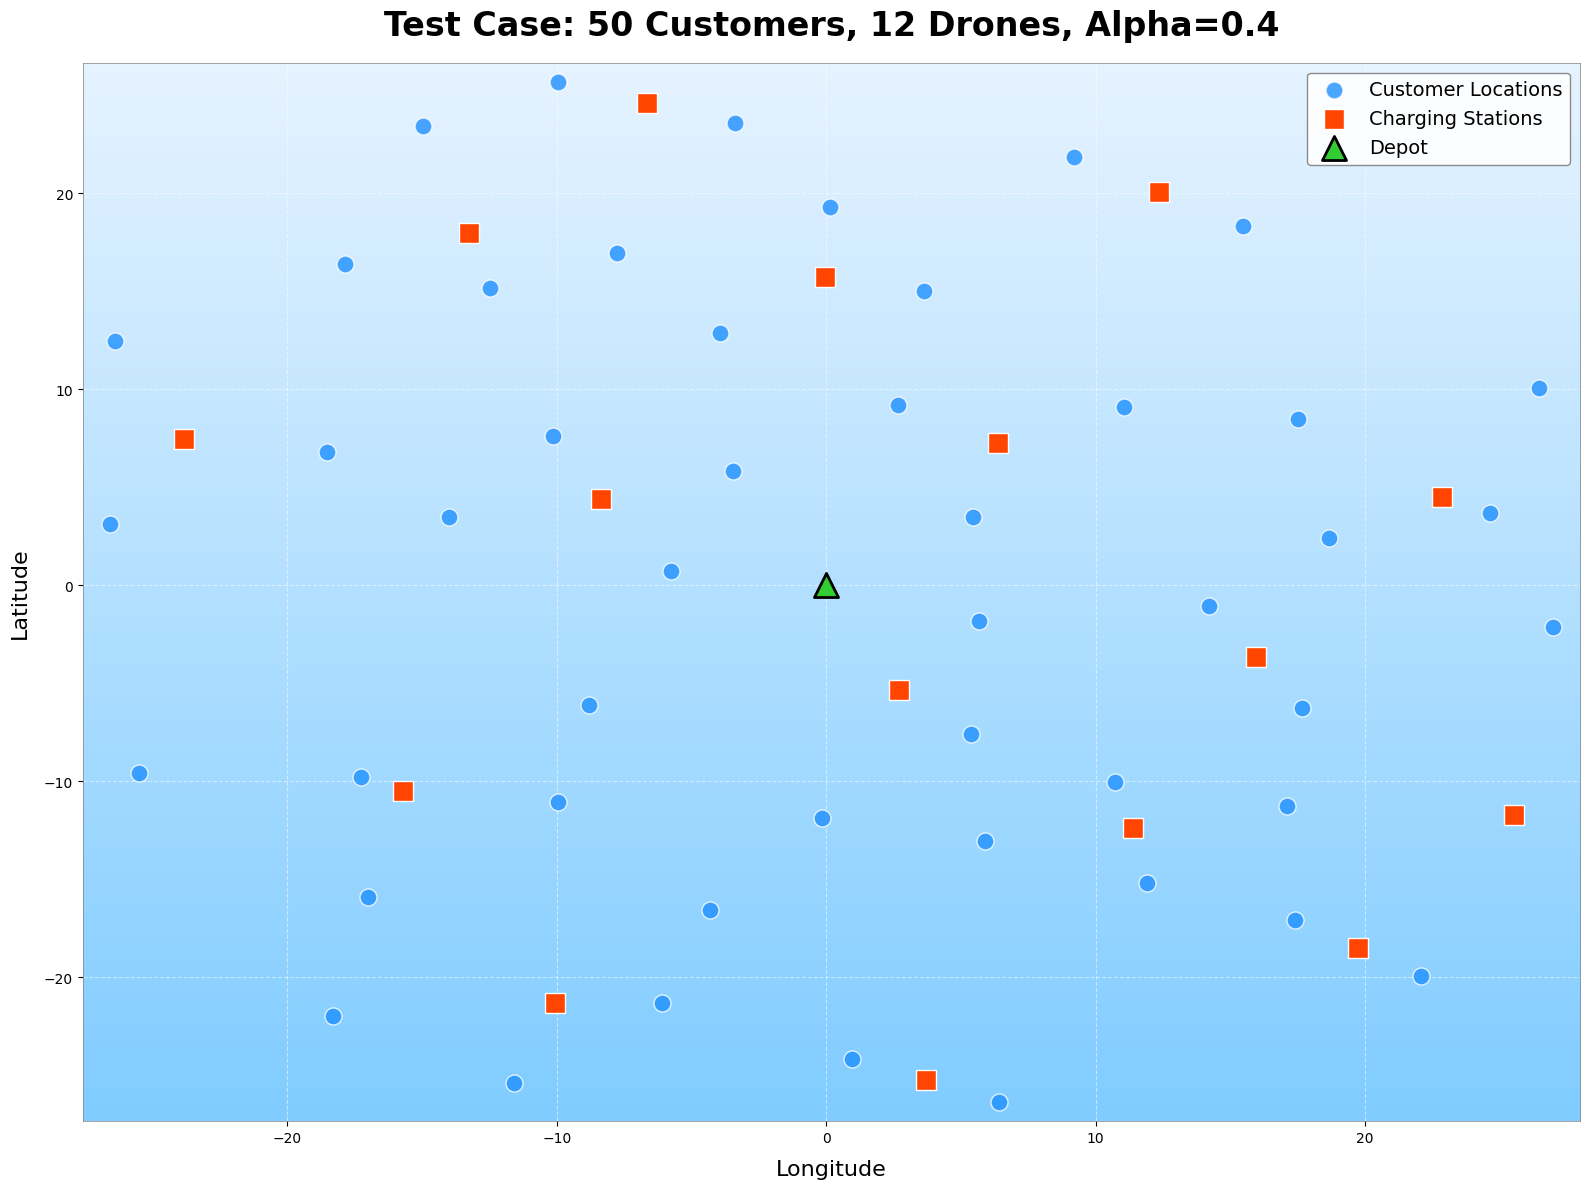

Plotted: customers_50/alpha_0.4/test_case_50_15_0.4.toml
Number of charging stations: 16
Number of customers: 50
--------------------


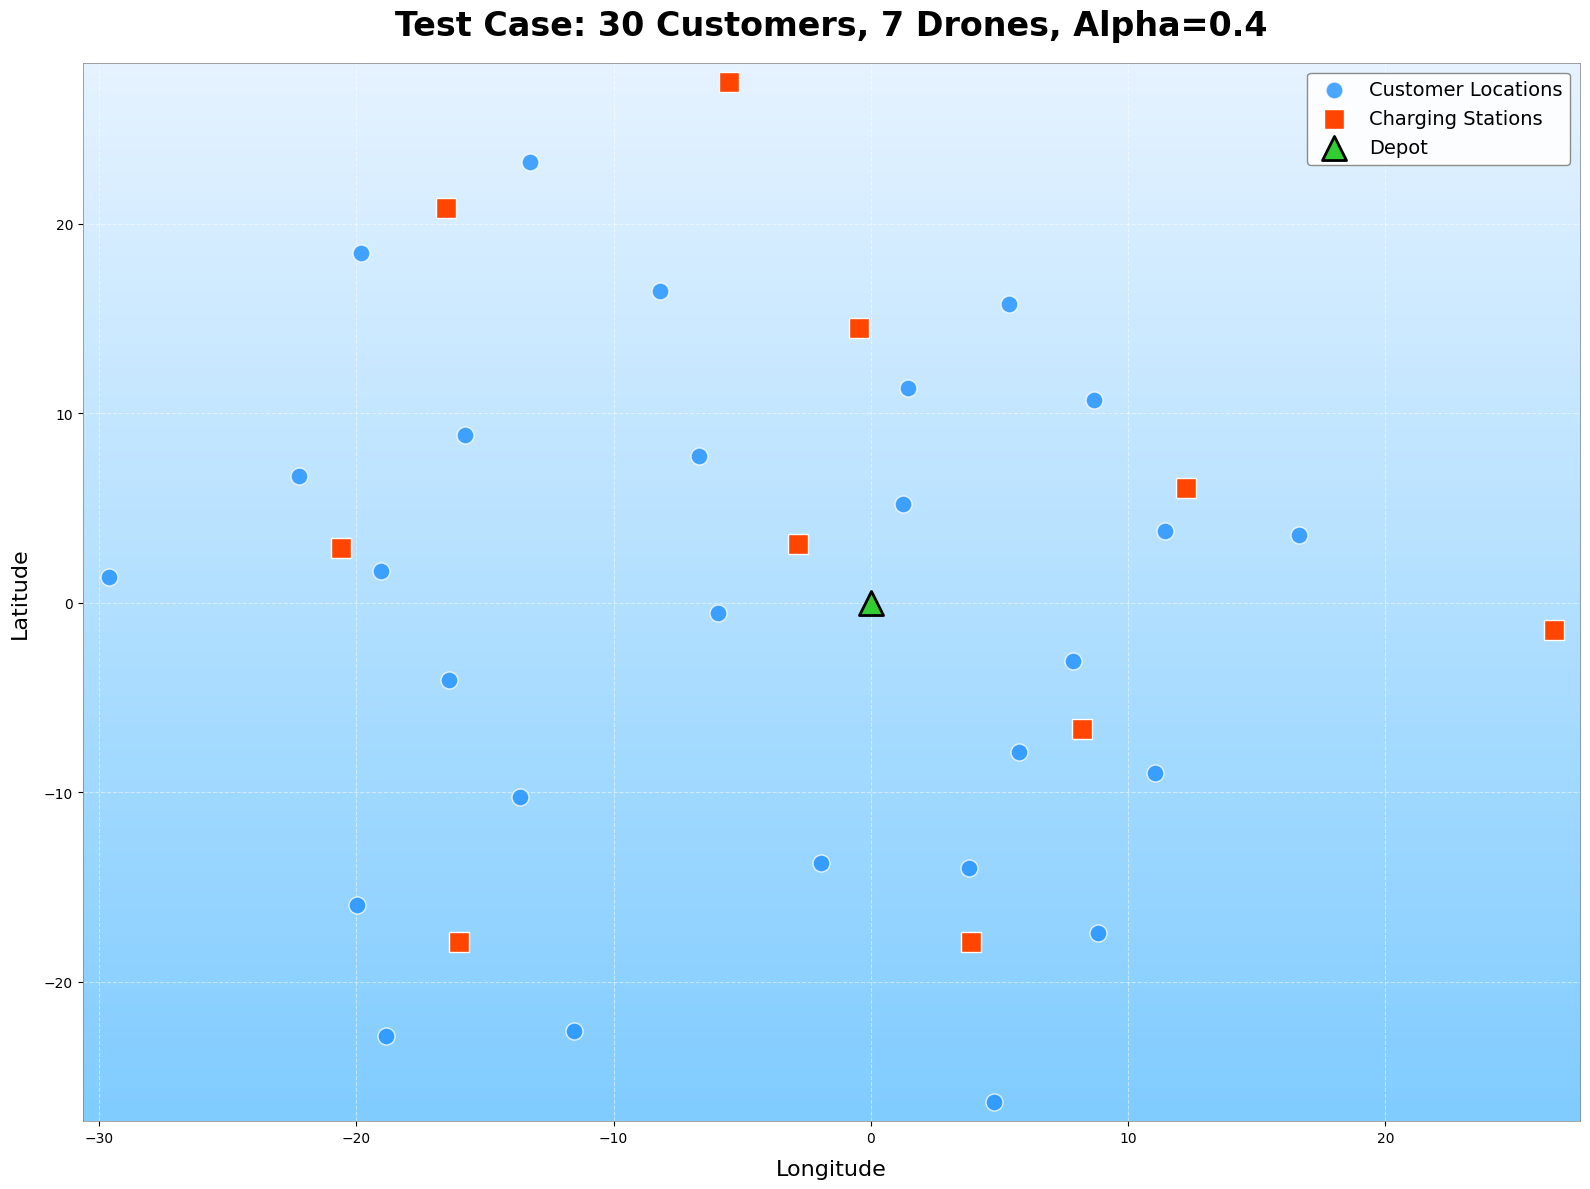

Plotted: customers_30/alpha_0.4/test_case_30_4_0.4.toml
Number of charging stations: 10
Number of customers: 30
--------------------


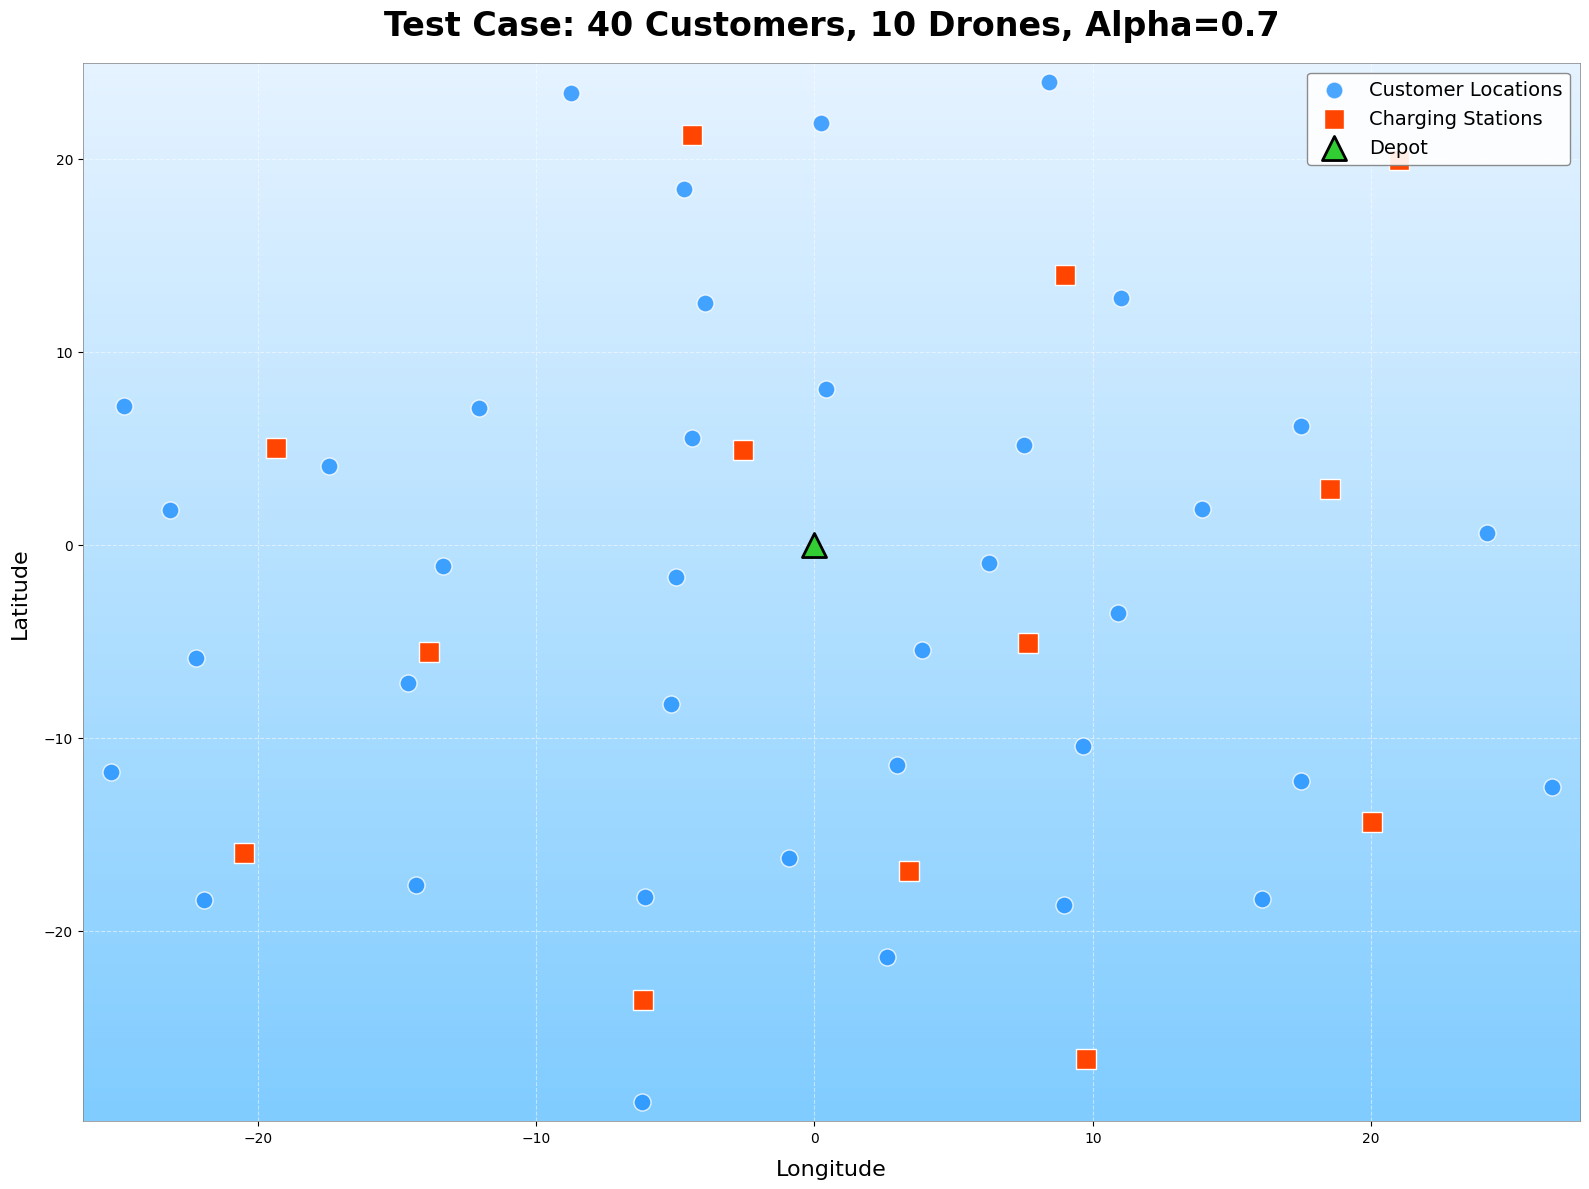

Plotted: customers_40/alpha_0.7/test_case_40_12_0.7.toml
Number of charging stations: 13
Number of customers: 40
--------------------


In [6]:
plot_random_test_cases()

### Section - 2: Algorithms

#### Bases Classes

In [7]:
class Tour:
    def __init__(self, num_drones):
        self.routes = [[] for _ in range(num_drones)]
        self.travel_costs = [0 for _ in range(num_drones)]
        self.delay_costs = [0 for _ in range(num_drones)]
        self.battery_levels = [[] for _ in range(num_drones)]

In [8]:
class RoutingAlgorithmBase:
    def __init__(self):
        self.best_solution = None

    def Set_Drone_Parameters(self, num_drones, initial_charging, drone_weight, drone_speed, drone_battery_capacity, drone_capacity, propeller_power_transfer_efficiency, lift_to_drag_ratio, energy_expenditure):
        self.num_drones = num_drones
        self.initial_charging = initial_charging
        self.drone_weight = drone_weight
        self.drone_speed = drone_speed
        self.drone_battery_capacity = drone_battery_capacity
        self.drone_capacity = drone_capacity
        self.propeller_power_transfer_efficiency = propeller_power_transfer_efficiency
        self.lift_to_drag_ratio = lift_to_drag_ratio
        self.energy_expenditure = energy_expenditure

    def Set_Charging_Station_Parameters(self, charging_rate, charging_cost):
        self.charging_rate = charging_rate
        self.charging_cost = charging_cost

    def Set_Tour_Parameters(self, distance_matrix, distance_between_charging_stations_customers, num_drones, customer_locations, charging_station_locations):
        self.number_of_customers = len(distance_matrix) - 1
        self.number_of_charging_stations = len(distance_between_charging_stations_customers[0])
        self.distance_matrix = distance_matrix
        self.distance_between_charging_stations_customers = distance_between_charging_stations_customers
        self.number_of_drones = num_drones
        self.customer_locations = customer_locations
        self.charging_station_locations = charging_station_locations

    def Set_Customer_Parameters(self, customer_items_weights, customer_deadlines, customer_heights):
        self.customer_items_weights = customer_items_weights
        self.customer_deadlines = customer_deadlines
        self.customer_heights = customer_heights

    def Discharging_Rate_Per_KM(self, load):
        power_loss = (self.drone_weight + load) * self.drone_speed / (370 * self.propeller_power_transfer_efficiency * self.lift_to_drag_ratio) + self.energy_expenditure
        return (power_loss / self.drone_speed) / self.drone_battery_capacity * 100

    def calculate_fitness(self, tour):
        for i, route in enumerate(tour.routes):
            tour.travel_costs[i] = self.calculate_travel_cost(route)
            tour.delay_costs[i] = self.calculate_delay_cost(route)
        
        max_travel_cost = max(tour.travel_costs) if tour.travel_costs else 0
        max_delay_cost = max(tour.delay_costs) if tour.delay_costs else 0
        fitness = self.alpha * max_travel_cost + (1 - self.alpha) * max_delay_cost + 1e-6
        return fitness

    def calculate_travel_cost(self, route):
        total_distance = 0    
        for i in range(len(route) - 1):
            current_location = route[i]
            next_location = route[i + 1]
            if current_location >= 0 and next_location >= 0:
                distance = self.distance_matrix[current_location][next_location]
            elif current_location < 0 and next_location >= 0:
                charging_station_index = -current_location - 1
                distance = self.distance_between_charging_stations_customers[next_location][charging_station_index]
            elif current_location >= 0 and next_location < 0:
                charging_station_index = -next_location - 1
                distance = self.distance_between_charging_stations_customers[current_location][charging_station_index]
            else:
                print(route)
                print("Not a Feasible route")
                exit()
            
            total_distance += distance
        return total_distance

    def calculate_delay_cost(self, route):
        delay_cost = 0
        current_time = 0
        
        for i in range(1, len(route) - 1):
            current_location = route[i]
            if current_location > 0:
                deadline = self.customer_deadlines[str(current_location - 1)]
                if current_time > deadline:
                    delay_cost += current_time - deadline
            
            next_location = route[i + 1]
            if current_location < 0:  # Charging station
                charging_time = self.drone_battery_capacity / self.charging_rate
                current_time += charging_time
            else:
                distance = self.distance_matrix[current_location][next_location]
                current_time += distance / self.drone_speed
        
        return delay_cost * self.drone_speed

    def find_nearest_charging_station(self, current_location):
        nearest_charging_station = 0
        min_distance = float('inf')
        for charging_station in range(self.number_of_charging_stations):
            distance = self.distance_between_charging_stations_customers[current_location][charging_station]
            if distance < min_distance:
                min_distance = distance
                nearest_charging_station = charging_station
        return nearest_charging_station

    def insert_charging_stations_population(self):
        for tour in self.population:
            for i in range(len(tour.routes)):
                tour.routes[i] = self.insert_charging_stations(tour.routes[i])

    def insert_charging_stations(self, route):
        new_route = [0]  # Start at depot
        current_battery = self.initial_charging
        battery_safety_margin = 20  # Increased to 20% safety margin
        
        # Calculate initial load
        current_load = sum(self.customer_items_weights.get(str(customer - 1), 0) for customer in route if customer > 0)
        
        for i in range(1, len(route)):  
            current_location = route[i]
            next_location = route[i+1] if i+1 < len(route) else 0
            
            # Calculate power needed for next leg
            power_needed = self.calculate_power_needed(new_route[-1], current_location, current_load)
            
            # Check if we need to insert a charging station
            if current_battery - power_needed < max(self.initial_charging * (battery_safety_margin / 100), power_needed * 1.5):
                # Don't insert a charging station if we just left one or the depot
                if new_route[-1] >= 0:
                    nearest_charging_station = self.find_nearest_charging_station(new_route[-1])
                    if nearest_charging_station is None:
                        raise ValueError(f"No charging station found near location {new_route[-1]}")
                    new_route.append(-(nearest_charging_station + 1))
                    current_battery = self.initial_charging
                    
                    # Recalculate power needed after charging
                    power_needed = self.calculate_power_needed(-(nearest_charging_station + 1), current_location, current_load)
            
            new_route.append(current_location)
            current_battery -= power_needed
            
            # Update load after visiting customer
            if current_location > 0:
                current_load = max(0, current_load - self.customer_items_weights.get(str(current_location - 1), 0))
        
        # Check if we need a final charge to return to depot
        final_power_needed = self.calculate_power_needed(new_route[-1], 0, current_load)
        if current_battery - final_power_needed < self.initial_charging * (battery_safety_margin / 100):
            nearest_charging_station = self.find_nearest_charging_station(new_route[-1])
            if nearest_charging_station is not None:
                new_route.append(-(nearest_charging_station + 1))
        
        return new_route

    def calculate_power_needed(self, from_location, to_location, load):
        if from_location < 0:
            distance = self.distance_between_charging_stations_customers[to_location][-from_location-1]
        elif to_location < 0:
            distance = self.distance_between_charging_stations_customers[from_location][-to_location-1]
        else:
            distance = self.distance_matrix[from_location][to_location]
        return self.Discharging_Rate_Per_KM(load) * distance

    def plot_best_solution(self, solution, generation=None):
        num_drones = len(solution.routes)
        fig, axs = plt.subplots(num_drones, 1, figsize=(15, 5 * num_drones))
        title = 'Best Solution - Individual Drone Routes'
        if generation is not None:
            title += f' at Generation {generation}'
        fig.suptitle(title, fontsize=16)
        
        if num_drones == 1:
            axs = [axs]
        
        colors = plt.cm.rainbow(np.linspace(0, 1, num_drones))
        
        for i, (route, ax) in enumerate(zip(solution.routes, axs)):
            # Plot depot
            depot = self.customer_locations[0]
            ax.scatter(depot[1], depot[0], color='red', s=100, marker='*', label='Depot')
            
            # Plot customer locations
            customer_locs = np.array(self.customer_locations[1:])
            ax.scatter(customer_locs[:, 1], customer_locs[:, 0], color='blue', s=50, label='Customers')
            
            # Plot charging stations
            charging_stations = np.array(self.charging_station_locations)
            ax.scatter(charging_stations[:, 1], charging_stations[:, 0], color='green', s=50, marker='s', label='Charging Stations')
            
            # Plot route with arrows
            route_coords = []
            for loc in route:
                if loc >= 0:
                    route_coords.append(self.customer_locations[loc])
                else:
                    route_coords.append(self.charging_station_locations[-loc-1])
            route_coords = np.array(route_coords)
            
            ax.plot(route_coords[:, 1], route_coords[:, 0], color=colors[i], label=f'Drone {i+1} Route')
            
            for j in range(len(route_coords) - 1):
                start = route_coords[j]
                end = route_coords[j+1]
                mid = (start + end) / 2
                dx = end[1] - start[1]
                dy = end[0] - start[0]
                
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                arrow_size = max(xlim[1]-xlim[0], ylim[1]-ylim[0]) / 100
                
                ax.arrow(mid[1], mid[0], dx/5, dy/5, color=colors[i], 
                         head_width=arrow_size, head_length=arrow_size*1, 
                         linewidth=2, length_includes_head=True,
                         zorder=10, alpha=0.7)
            
            ax.set_title(f'Drone {i+1} Route')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        if generation is not None:
            #plt.show()
            plt.close()
        else:
            plt.show()

    def calculate_battery_levels(self, tour):
        for i, route in enumerate(tour.routes):
            battery_level = self.initial_charging
            battery_levels = [battery_level]
            
            # Calculate initial load
            current_load = sum(self.customer_items_weights.get(str(customer - 1), 0) for customer in route if customer > 0)
            
            for j in range(1, len(route)):
                prev_location = route[j-1]
                current_location = route[j]
                
                # Calculate distance
                distance = self.calculate_distance(prev_location, current_location)
                
                # Calculate power needed for this leg
                power_needed = self.Discharging_Rate_Per_KM(current_load) * distance
                
                if current_location < 0:  # If it's a charging station
                    battery_level = self.initial_charging
                else:
                    battery_level = max(0, battery_level - power_needed)  # Ensure battery level doesn't go below 0
                
                if current_location > 0:  # If it's a customer
                    # Reduce load after delivering to the customer
                    current_load -= self.customer_items_weights.get(str(current_location - 1), 0)
                
                battery_levels.append(battery_level)
            
            tour.battery_levels[i] = battery_levels
    
        # Print debug information
        print(f"Battery levels calculated for {len(tour.routes)} routes:")
        for i, levels in enumerate(tour.battery_levels):
            print(f"  Route {i + 1}: {len(levels)} levels, {levels}")

    def print_routes(self, solution, generation):
        print(f"Best Solution at Generation {generation}:")
        print(f"Number of routes: {len(solution.routes)}")
        
        total_distance = 0
        total_travel_cost = 0
        total_delay_cost = 0
        
        for i, route in enumerate(solution.routes):
            print(f"Drone {i + 1}:")
            print(f"  Route: {route}")
            
            route_distance = 0
            current_load = sum(self.customer_items_weights.get(str(customer - 1), 0) for customer in route if customer > 0)
            
            if hasattr(solution, 'battery_levels') and i < len(solution.battery_levels):
                battery_levels = solution.battery_levels[i]
            else:
                print("  Warning: Battery levels not available for this route")
                battery_levels = [self.initial_charging] * len(route)  # Assume initial charging for all stops if data is missing
            
            for j in range(len(route)):
                current_location = route[j]
                current_battery = battery_levels[j]
                
                if j > 0:
                    prev_location = route[j-1]
                    distance = self.calculate_distance(prev_location, current_location)
                    route_distance += distance
                else:
                    distance = 0  # First stop (depot)
                
                if current_location > 0:  # If it's a customer
                    current_load -= self.customer_items_weights.get(str(current_location - 1), 0)
                
                location_type = "Depot" if current_location == 0 else f"Customer {current_location}" if current_location > 0 else f"Charging Station {-current_location}"
                
                print(f"    {location_type}, Distance from previous: {distance:.2f} km, Current load: {current_load:.2f}, Battery: {current_battery:.2f}%")
            
            total_distance += route_distance
            print(f"  Total Route Distance: {route_distance:.2f} km")
            
            if hasattr(solution, 'travel_costs') and i < len(solution.travel_costs):
                print(f"  Travel Cost: {solution.travel_costs[i]:.2f}")
                total_travel_cost += solution.travel_costs[i]
            
            if hasattr(solution, 'delay_costs') and i < len(solution.delay_costs):
                print(f"  Delay Cost: {solution.delay_costs[i]:.2f}")
                total_delay_cost += solution.delay_costs[i]
            
            print()  # Empty line for readability
        
        print(f"Total Distance Across All Routes: {total_distance:.2f} km")
        print(f"Total Travel Cost: {total_travel_cost:.2f}")
        print(f"Total Delay Cost: {total_delay_cost:.2f}")
        
        if hasattr(solution, 'travel_costs') and hasattr(solution, 'delay_costs'):
            fitness = self.calculate_fitness(solution)
            print(f"Overall Fitness: {fitness:.2f}")

    def plot_fitness_over_generations(self, fitness_values):
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(fitness_values) + 1), fitness_values, 'b-')
        plt.title('Best (Minimum) Fitness Value Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness Value (Lower is Better)')
        plt.grid(True)
        
        # Only use log scale if all values are positive and vary greatly
        if all(f > 0 for f in fitness_values) and max(fitness_values) / min(fitness_values) > 100:
            plt.yscale('log')
        
        plt.tight_layout()
        plt.show()

    def calculate_distance(self, from_location, to_location):
        if from_location >= 0 and to_location >= 0:
            return self.distance_matrix[from_location][to_location]
        elif from_location < 0 and to_location >= 0:
            charging_station_index = -from_location - 1
            return self.distance_between_charging_stations_customers[to_location][charging_station_index]
        elif from_location >= 0 and to_location < 0:
            charging_station_index = -to_location - 1
            return self.distance_between_charging_stations_customers[from_location][charging_station_index]
        else:
            print(f"Warning: Invalid route segment from {from_location} to {to_location}")
            return 0
    

#### Section  2.1 : Simulated Annealing

In [10]:
class SimulatedAnnealing(RoutingAlgorithmBase):
    def __init__(self):
        super().__init__()
        self.current_solution = None

    def Set_SA_Parameters(self, initial_temperature, cooling_rate, num_iterations, alpha=0.5):
        self.initial_temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.num_iterations = num_iterations
        self.alpha = alpha

    def generate_initial_solution(self):
        tour = Tour(self.num_drones)
        remaining_customers = list(range(1, self.number_of_customers + 1))
        random.shuffle(remaining_customers)
        
        for customer in remaining_customers:
            best_drone = min(range(self.num_drones), key=lambda i: sum(self.customer_items_weights.get(str(c - 1), 0) for c in tour.routes[i]))
            tour.routes[best_drone].append(customer)
        
        for i in range(self.num_drones):
            tour.routes[i] = [0] + tour.routes[i] + [0]
            tour.routes[i] = self.insert_charging_stations(tour.routes[i])
        
        return tour

    def generate_neighbor(self, solution):
        new_solution = Tour(self.num_drones)
        for i, route in enumerate(solution.routes):
            new_solution.routes[i] = route.copy()
        
        route1, route2 = random.sample(range(self.num_drones), 2)
        if len(new_solution.routes[route1]) > 2 and len(new_solution.routes[route2]) > 2:
            idx1 = random.randint(1, len(new_solution.routes[route1]) - 2)
            idx2 = random.randint(1, len(new_solution.routes[route2]) - 2)
            new_solution.routes[route1][idx1], new_solution.routes[route2][idx2] = new_solution.routes[route2][idx2], new_solution.routes[route1][idx1]
        
        for i in range(self.num_drones):
            new_solution.routes[i] = self.insert_charging_stations(new_solution.routes[i])
        
        return new_solution

    def run_algorithm(self):
        self.current_solution = self.generate_initial_solution()
        best_solution = self.current_solution
        current_temperature = self.initial_temperature

        for iteration in range(self.num_iterations):
            neighbor = self.generate_neighbor(self.current_solution)
            
            current_fitness = self.calculate_fitness(self.current_solution)
            neighbor_fitness = self.calculate_fitness(neighbor)
            
            if neighbor_fitness < current_fitness or random.random() < math.exp((current_fitness - neighbor_fitness) / current_temperature):
                self.current_solution = neighbor
            
            if self.calculate_fitness(self.current_solution) < self.calculate_fitness(best_solution):
                best_solution = self.current_solution

            current_temperature *= self.cooling_rate

            if iteration % 100 == 0:
                print(f"Iteration {iteration}, Temperature: {current_temperature:.2f}, Best Fitness: {self.calculate_fitness(best_solution):.2f}")

        self.best_solution = best_solution
        return best_solution

#### Section  2.2: Greedy Heursistc Algorithm

In [11]:
class GreedyHeuristic(RoutingAlgorithmBase):
    def __init__(self):
        super().__init__()

    def Set_Greedy_Parameters(self, alpha=0.5):
        self.alpha = alpha

    def find_nearest_customer(self, current_location, unvisited_customers):
        nearest_customer = None
        min_distance = float('inf')
        for customer in unvisited_customers:
            distance = self.distance_matrix[current_location][customer]
            if distance < min_distance:
                min_distance = distance
                nearest_customer = customer
        return nearest_customer, min_distance

    def run_algorithm(self):
        solution = Tour(self.num_drones)
        unvisited_customers = set(range(1, self.number_of_customers + 1))
        
        for drone in range(self.num_drones):
            current_location = 0  # Start at depot
            current_capacity = self.drone_capacity
            current_battery = self.initial_charging
            route = [current_location]

            while unvisited_customers and current_capacity > 0:
                nearest_customer, distance = self.find_nearest_customer(current_location, unvisited_customers)
                
                if nearest_customer is None:
                    break
                
                customer_weight = self.customer_items_weights.get(str(nearest_customer - 1), 0)
                power_needed = self.calculate_power_needed(current_location, nearest_customer, current_capacity)
                
                if current_capacity >= customer_weight and current_battery >= power_needed:
                    route.append(nearest_customer)
                    unvisited_customers.remove(nearest_customer)
                    current_location = nearest_customer
                    current_capacity -= customer_weight
                    current_battery -= power_needed
                else:
                    charging_station = self.find_nearest_charging_station(current_location)
                    route.append(-(charging_station + 1))
                    current_location = -(charging_station + 1)
                    current_battery = self.initial_charging

            route.append(0)  # Return to depot
            solution.routes[drone] = route

        self.best_solution = solution
        return solution

### Section - 4: Main Execution of Algorithms & Results 

#### Section - 4.1: Run Functions

In [12]:
def load_test_case(filename):
    with open(filename, 'r') as f:
        return toml.load(f)
def format_test_case_data(raw_test_case):
    locations = raw_test_case['customer_locations']
    charging_stations = raw_test_case['charging_stations']
    distance_matrix = construct_adjacency_matrix(locations)
    distance_between_charging_stations_customers = construct_charging_stations_distances(
        locations, charging_stations
    )

    formatted_data = {
        'drone_params': {
            'num_drones': raw_test_case['num_drones'],
            'initial_charging': raw_test_case['initial_charging'],
            'drone_weight': raw_test_case['drone_weight'],
            'drone_speed': raw_test_case['drone_speed'],
            'drone_battery_capacity': raw_test_case['drone_battery_capacity'],
            'drone_capacity': raw_test_case['drone_capacity'],
            'propeller_power_transfer_efficiency': raw_test_case['propeller_power_transfer_efficiency'],
            'lift_to_drag_ratio': raw_test_case['lift_to_drag_ratio'],
            'energy_expenditure': raw_test_case['energy_expenditure']
        },
        'charging_params': {
            'charging_rate': raw_test_case['charging_rate'],
            'charging_cost': raw_test_case['charging_cost']
        },
        'tour_params': {
            'distance_matrix': distance_matrix,
            'distance_between_charging_stations_customers': distance_between_charging_stations_customers,
            'num_drones': raw_test_case['num_drones'],
            'customer_locations': locations,
            'charging_station_locations': charging_stations
        },
        'customer_params': {
            'customer_items_weights': raw_test_case['customer_items_weights'],
            'customer_deadlines': raw_test_case['customer_deadlines'],
            'customer_heights': raw_test_case['customer_heights']
        },
        'alpha': raw_test_case['alpha']
    }
    
    return formatted_data
def process_test_case(test_case_file, base_directory, num_runs=5):
    raw_test_case = load_test_case(os.path.join(base_directory, test_case_file))
    test_case_data = format_test_case_data(raw_test_case)
    
    algorithms = [
        (SimulatedAnnealing, {
            'initial_temperature': 1000,
            'cooling_rate': 0.995,
            'num_iterations': 10000,
            'alpha': test_case_data['alpha']
        }),
        (GreedyHeuristic, {
            'alpha': test_case_data['alpha']
        })
    ]
    
    results = []
    for algorithm_class, params in algorithms:
        algorithm_results = []
        for _ in range(num_runs):
            try:
                result = run_algorithm(algorithm_class, test_case_data, params)
                algorithm_results.append(result)
            except Exception as e:
                logging.error(f"Error running {algorithm_class.__name__}: {str(e)}")
                logging.exception("Exception details:")
                continue
        
        if algorithm_results:
            avg_result = {
                'algorithm': algorithm_class.__name__,
                'avg_fitness': np.mean([r['fitness'] for r in algorithm_results]),
                'avg_travel_cost': np.mean([r['travel_cost'] for r in algorithm_results]),
                'avg_delay_cost': np.mean([r['delay_cost'] for r in algorithm_results]),
                'avg_execution_time': np.mean([r['execution_time'] for r in algorithm_results]),
                'num_customers': test_case_data['tour_params']['number_of_customers'],
                'num_drones': test_case_data['tour_params']['num_drones'],
                'num_charging_stations': test_case_data['tour_params']['number_of_charging_stations'],
                'alpha': test_case_data['alpha']
            }
            results.append(avg_result)
        else:
            logging.warning(f"No valid results for {algorithm_class.__name__} on test case {test_case_file}")
    
    return results

def run_algorithm(algorithm_class, test_case_data, algorithm_params):

    algorithm = algorithm_class()
    algorithm.Set_Drone_Parameters(**test_case_data['drone_params'])
    algorithm.Set_Charging_Station_Parameters(**test_case_data['charging_params'])
    algorithm.Set_Tour_Parameters(**test_case_data['tour_params'])
    algorithm.Set_Customer_Parameters(**test_case_data['customer_params'])
    
    if algorithm_class == GeneticAlgorithm:
        algorithm.Set_Genetic_Parameters(**algorithm_params)
    elif algorithm_class == SimulatedAnnealing:
        algorithm.Set_SA_Parameters(**algorithm_params)
    elif algorithm_class == GreedyHeuristic:
        algorithm.Set_Greedy_Parameters(**algorithm_params)
    
    start_time = time.time()
    best_solution = algorithm.run_algorithm()
    end_time = time.time()
    
    return {
        'fitness': algorithm.calculate_fitness(best_solution),
        'travel_cost': sum(best_solution.travel_costs),
        'delay_cost': sum(best_solution.delay_costs),
        'execution_time': end_time - start_time
    }

#### Section - 4.2: Main Execution


Testing GeneticAlgorithm...

Testing GeneticAlgorithm

Starting algorithm execution...
Discharging Rate for load per km:  0.4369369369369369
Generation:  1
Over all Best Fitness:  104.49781393576536
Generation:  2
Over all Best Fitness:  104.49781393576536
Generation:  3
Over all Best Fitness:  91.58878499951436
Generation:  4
Over all Best Fitness:  84.78782358037783
Generation:  5
Over all Best Fitness:  84.78782358037783
Generation:  6
Over all Best Fitness:  84.78782358037783
Generation:  7
Over all Best Fitness:  84.78782358037783
Generation:  8
Over all Best Fitness:  84.78782358037783
Generation:  9
Over all Best Fitness:  84.78782358037783
Generation:  10
Over all Best Fitness:  84.78782358037783
Generation:  11
Over all Best Fitness:  84.78782358037783
Generation:  12
Over all Best Fitness:  84.78782358037783
Generation:  13
Over all Best Fitness:  84.78782358037783
Generation:  14
Over all Best Fitness:  84.78782358037783
Generation:  15
Over all Best Fitness:  84.7878235803

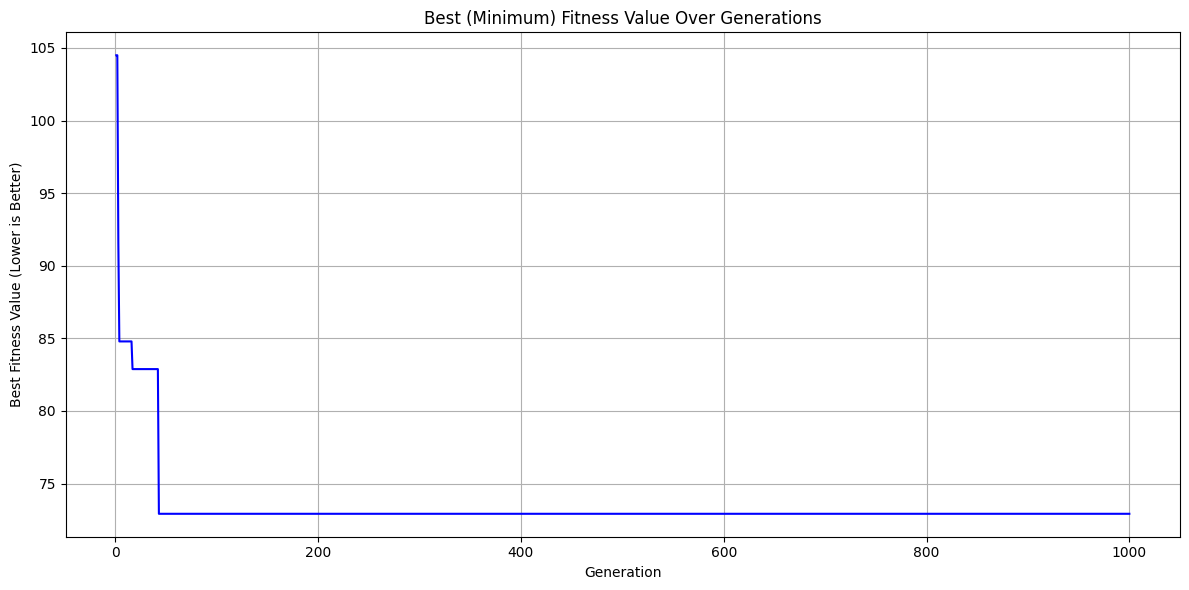

Battery levels calculated for 5 routes:
  Route 1: 10 levels, [100, 74.15952560165574, 56.80788862173252, 48.75780612753775, 100, 69.7180342461204, 64.00561051767019, 52.84944360620277, 49.18892351099496, 46.90744268220192]
  Route 2: 5 levels, [100, 80.39841207925843, 68.98652914599502, 47.87609250664718, 35.22943821042856]
  Route 3: 5 levels, [100, 88.32087915580264, 68.60606357561093, 65.22847198135892, 56.579933966739205]
  Route 4: 5 levels, [100, 77.42531051013293, 64.02002577182827, 50.485138396904375, 40.52632764319932]
  Route 5: 5 levels, [100, 83.360189324315, 55.57829094712946, 42.44738095078169, 39.987088089610005]

Detailed Results:
----------------------------------------
Best Solution at Generation Final:
Number of routes: 5
Drone 1:
  Route: [0, 14, 3, 18, -5, 4, 12, 9, 13, 0]
    Depot, Distance from previous: 0.00 km, Current load: 8.10, Battery: 100.00%
    Customer 14, Distance from previous: 16.87 km, Current load: 6.86, Battery: 74.16%
    Customer 3, Distance f

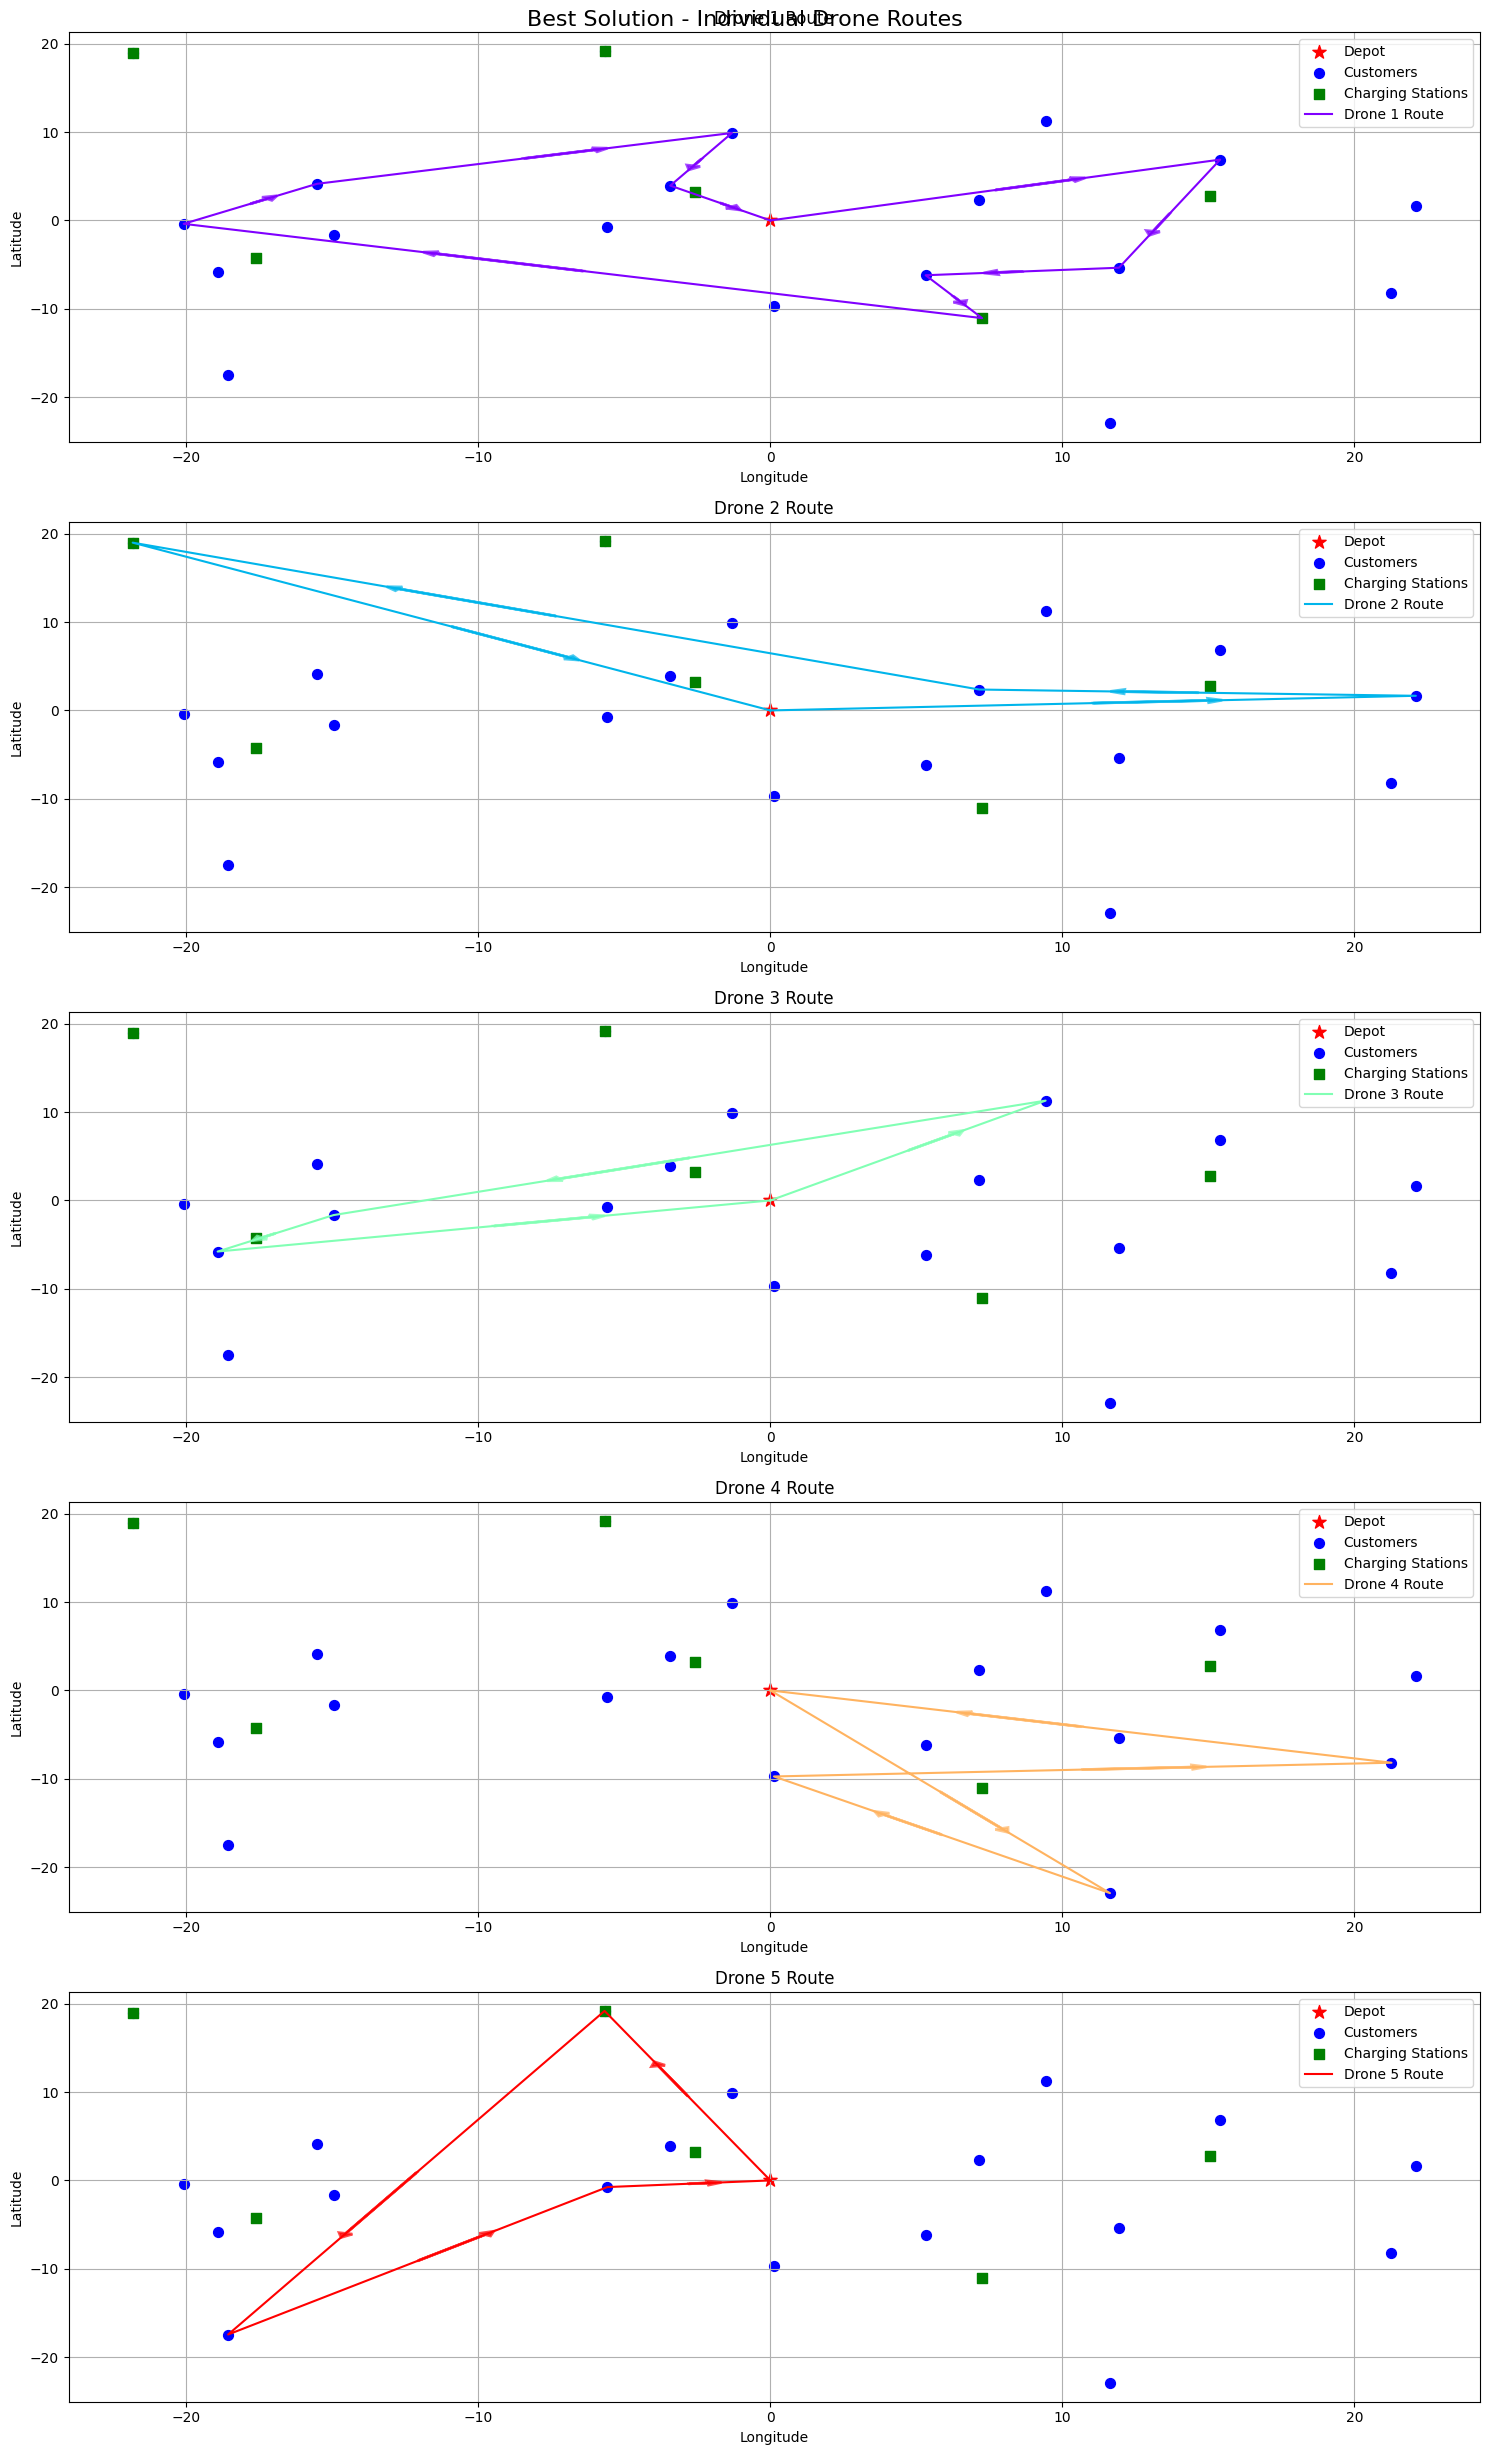


Analyzing battery usage...


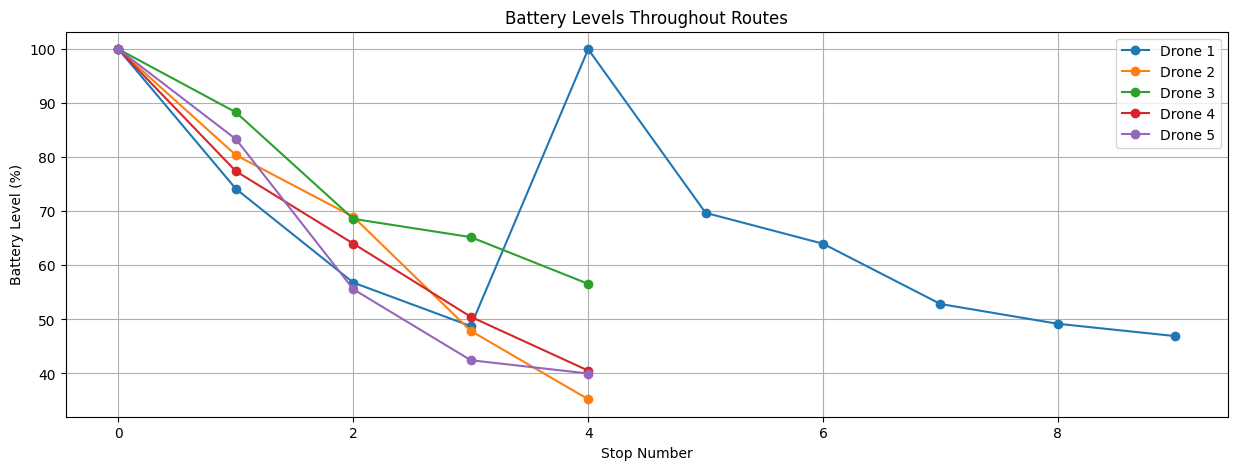


Comparing route metrics...


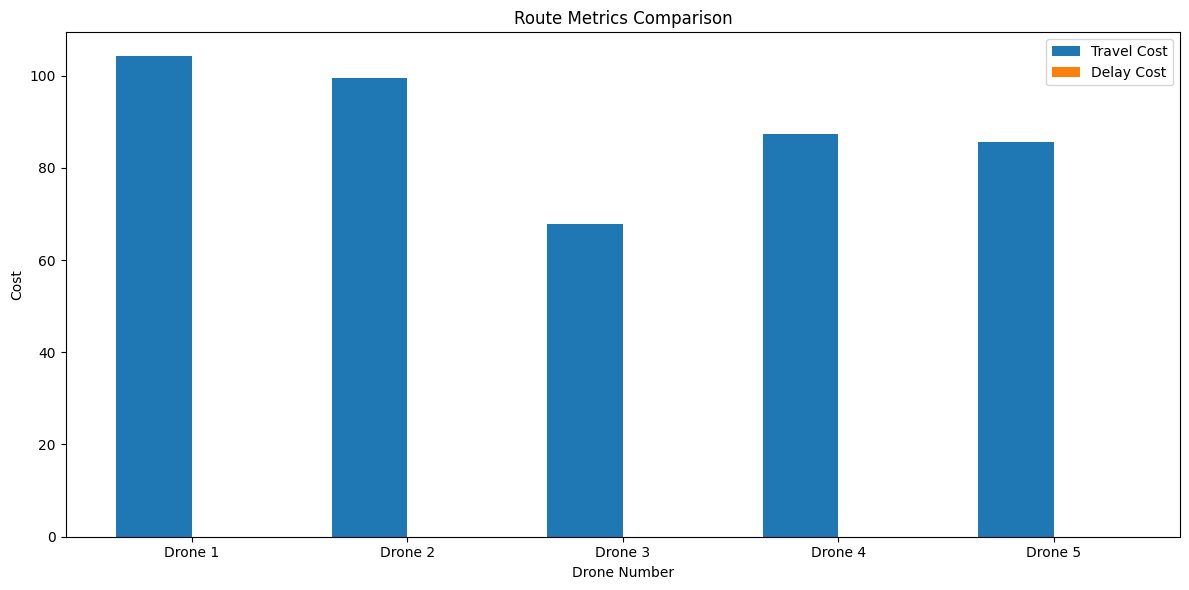


Press Enter to continue to next algorithm...



Testing SimulatedAnnealing...

Testing SimulatedAnnealing

Starting algorithm execution...
Iteration 0, Temperature: 995.00, Best Fitness: 97.15
[0, 7, 16, -1, 8, -5, 4, -4, -4, 0]
Not a Feasible route
[0, 7, 16, -1, 8, -5, 4, -4, -4, 0]
Not a Feasible route
[0, 7, 16, -1, 8, -5, 4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, 0]
Not a Feasible route
[0, 14, 10, 12, -4, 19, -2, 0, -3, -3]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, -4, 0]
Not a Feasible route
[0, 1, 16, -1, 8, -5, 4, -4, -4, -4, -4, 0]
Not a Feasible route
[0, 14, 10, 12, -4, 19, -2, 0, -3, -3]
Not a Feasible route
[0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
def test_single_algorithm(algorithm_class, test_case_file, algorithm_params=None):
    """
    Test a single algorithm with detailed output and analysis.
    """
    print(f"\n{'='*80}")
    print(f"Testing {algorithm_class.__name__}")
    print(f"{'='*80}\n")
    
    # Load and format test case data
    raw_test_case = load_test_case(test_case_file)
    test_case_data = format_test_case_data(raw_test_case)
    
    # Set default algorithm parameters if none provided
    if algorithm_params is None:
        if algorithm_class == GeneticAlgorithm:
            algorithm_params = {
                'population_size': 100,
                'mutation_rate': 0.01,
                'crossover_rate': 0.8,
                'num_generations': 1000,
                'alpha': test_case_data['alpha']
            }
        elif algorithm_class == SimulatedAnnealing:
            algorithm_params = {
                'initial_temperature': 1000,
                'cooling_rate': 0.995,
                'num_iterations': 10000,
                'alpha': test_case_data['alpha']
            }
        else:  # GreedyHeuristic
            algorithm_params = {
                'alpha': test_case_data['alpha']
            }
    
    # Initialize and run algorithm
    algorithm = algorithm_class()
    algorithm.Set_Drone_Parameters(**test_case_data['drone_params'])
    algorithm.Set_Charging_Station_Parameters(**test_case_data['charging_params'])
    algorithm.Set_Tour_Parameters(**test_case_data['tour_params'])
    algorithm.Set_Customer_Parameters(**test_case_data['customer_params'])
    
    if algorithm_class == GeneticAlgorithm:
        algorithm.Set_Genetic_Parameters(**algorithm_params)
    elif algorithm_class == SimulatedAnnealing:
        algorithm.Set_SA_Parameters(**algorithm_params)
    elif algorithm_class == GreedyHeuristic:
        algorithm.Set_Greedy_Parameters(**algorithm_params)
    
    print("Starting algorithm execution...")
    start_time = time.time()
    best_solution = algorithm.run_algorithm()
    end_time = time.time()
    
    # Calculate battery levels
    algorithm.calculate_battery_levels(best_solution)
    
    # Print detailed results
    print("\nDetailed Results:")
    print("-" * 40)
    algorithm.print_routes(best_solution, 'Final')
    
    # Plot solution
    print("\nGenerating visualization...")
    algorithm.plot_best_solution(best_solution)
    
    # Return results dictionary
    return {
        'algorithm': algorithm_class.__name__,
        'execution_time': end_time - start_time,
        'fitness': algorithm.calculate_fitness(best_solution),
        'travel_costs': best_solution.travel_costs,
        'delay_costs': best_solution.delay_costs,
        'battery_levels': best_solution.battery_levels,
        'solution': best_solution
    }

def analyze_battery_usage(results):
    """
    Analyze battery usage patterns from algorithm results.
    """
    plt.figure(figsize=(15, 5))
    
    for drone_idx, levels in enumerate(results['battery_levels']):
        plt.plot(levels, label=f'Drone {drone_idx + 1}', marker='o')
    
    plt.title('Battery Levels Throughout Routes')
    plt.xlabel('Stop Number')
    plt.ylabel('Battery Level (%)')
    plt.grid(True)
    plt.legend()
    plt.show()

def compare_route_metrics(results):
    """
    Compare metrics between different routes in the solution.
    """
    n_drones = len(results['travel_costs'])
    
    # Prepare data
    metrics = {
        'Travel Cost': results['travel_costs'],
        'Delay Cost': results['delay_costs']
    }
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(n_drones)
    width = 0.35
    
    ax.bar(x - width/2, metrics['Travel Cost'], width, label='Travel Cost')
    ax.bar(x + width/2, metrics['Delay Cost'], width, label='Delay Cost')
    
    ax.set_title('Route Metrics Comparison')
    ax.set_xlabel('Drone Number')
    ax.set_ylabel('Cost')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Drone {i+1}' for i in range(n_drones)])
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Select a test case
    test_case_file = "test_cases/customers_20/alpha_0.7/test_case_20_1_0.7.toml"
    
    # Test each algorithm separately
    algorithms = [GeneticAlgorithm, SimulatedAnnealing, GreedyHeuristic]
    all_results = {}
    
    for algorithm_class in algorithms:
        print(f"\nTesting {algorithm_class.__name__}...")
        results = test_single_algorithm(algorithm_class, test_case_file)
        all_results[algorithm_class.__name__] = results
        
        # Analyze battery usage
        print("\nAnalyzing battery usage...")
        analyze_battery_usage(results)
        
        # Compare route metrics
        print("\nComparing route metrics...")
        compare_route_metrics(results)
        
        print("\nPress Enter to continue to next algorithm...")
        input()
    
    # Compare algorithms
    print("\nAlgorithm Comparison Summary:")
    print("-" * 60)
    comparison_data = {
        'Fitness': [r['fitness'] for r in all_results.values()],
        'Execution Time': [r['execution_time'] for r in all_results.values()],
        'Avg Travel Cost': [np.mean(r['travel_costs']) for r in all_results.values()],
        'Avg Delay Cost': [np.mean(r['delay_costs']) for r in all_results.values()]
    }
    
    comparison_df = pd.DataFrame(comparison_data, index=all_results.keys())
    print(comparison_df.round(2))

#### Section 4.3: Parallel Processing Result Execution

In [ ]:
def run_experiments(base_directory='test_cases', max_parallel_processes=4):
    """
    Run experiments across all test cases with parallel processing
    """
    # Setup logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(f'experiment_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'),
            logging.StreamHandler()
        ]
    )
    
    logging.info("Starting experiments...")
    
    # Load test cases metadata
    try:
        with open(os.path.join(base_directory, 'test_cases_metadata.json'), 'r') as f:
            test_cases = json.load(f)
    except FileNotFoundError:
        logging.error(f"Test cases metadata file not found in {base_directory}")
        raise
    
    # Initialize results storage
    all_results = []
    
    # Process test cases in parallel
    with ProcessPoolExecutor(max_workers=max_parallel_processes) as executor:
        # Submit all jobs
        future_to_case = {
            executor.submit(process_test_case, case['filename'], base_directory): case 
            for case in test_cases
        }
        
        # Process completed futures
        for future in as_completed(future_to_case):
            case = future_to_case[future]
            try:
                results = future.result()
                all_results.extend(results)
                logging.info(f"Completed test case: {case['filename']}")
            except Exception as e:
                logging.error(f"Error processing test case {case['filename']}: {str(e)}")
                logging.exception("Exception details:")
    
    # Convert results to DataFrame
    if not all_results:
        logging.error("No results were generated")
        raise RuntimeError("No results were generated from the experiments")
    
    results_df = pd.DataFrame(all_results)
    logging.info(f"Completed all experiments. Processed {len(test_cases)} test cases.")
    
    return results_df

def plot_results(results_df):
    """
    Create visualization plots for the results
    """
    try:
        # Create output directory for plots
        plots_dir = 'results/plots'
        os.makedirs(plots_dir, exist_ok=True)
        
        # Set style for all plots
        plt.style.use('seaborn')
        
        # 1. Performance by Problem Size
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=results_df, x='num_customers', y='avg_fitness', hue='algorithm')
        plt.title('Algorithm Performance by Problem Size')
        plt.xlabel('Number of Customers')
        plt.ylabel('Average Fitness (lower is better)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'performance_by_size.png'))
        plt.close()
        
        # 2. Execution Time Analysis
        plt.figure(figsize=(15, 8))
        sns.lineplot(data=results_df, x='num_customers', y='avg_execution_time', 
                    hue='algorithm', style='algorithm', markers=True, dashes=False)
        plt.title('Execution Time by Problem Size')
        plt.xlabel('Number of Customers')
        plt.ylabel('Average Execution Time (seconds)')
        plt.yscale('log')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'execution_time.png'))
        plt.close()
        
        # 3. Trade-off Analysis
        plt.figure(figsize=(15, 8))
        scatter = plt.scatter(results_df['avg_travel_cost'], results_df['avg_delay_cost'],
                            c=results_df['alpha'], cmap='viridis',
                            s=100, alpha=0.6)
        plt.colorbar(scatter, label='Alpha Value')
        plt.title('Trade-off between Travel Cost and Delay Cost')
        plt.xlabel('Average Travel Cost')
        plt.ylabel('Average Delay Cost')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'cost_tradeoff.png'))
        plt.close()
        
        # 4. Performance by Alpha Value
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=results_df, x='alpha', y='avg_fitness', hue='algorithm')
        plt.title('Algorithm Performance by Alpha Value')
        plt.xlabel('Alpha Value')
        plt.ylabel('Average Fitness (lower is better)')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'performance_by_alpha.png'))
        plt.close()
        
        logging.info("Successfully generated all plots")
        
    except Exception as e:
        logging.error(f"Error generating plots: {str(e)}")
        logging.exception("Exception details:")
        raise

def save_results(results_df, output_dir='results'):
    """
    Save results to files
    """
    try:
        # Create results directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Save full results to CSV
        results_df.to_csv(os.path.join(output_dir, 'full_results.csv'), index=False)
        
        # Generate and save summary statistics
        summary_stats = results_df.groupby(['algorithm', 'num_customers']).agg({
            'avg_fitness': ['mean', 'std', 'min', 'max'],
            'avg_execution_time': ['mean', 'std']
        }).round(3)
        
        summary_stats.to_csv(os.path.join(output_dir, 'summary_statistics.csv'))
        
        # Create performance comparison report
        with open(os.path.join(output_dir, 'performance_report.txt'), 'w') as f:
            f.write("Algorithm Performance Report\n")
            f.write("=========================\n\n")
            
            # Best performing algorithm for each problem size
            best_by_size = results_df.loc[results_df.groupby('num_customers')['avg_fitness'].idxmin()]
            f.write("Best Performing Algorithm by Problem Size:\n")
            for _, row in best_by_size.iterrows():
                f.write(f"Customers: {row['num_customers']}, "
                       f"Algorithm: {row['algorithm']}, "
                       f"Fitness: {row['avg_fitness']:.3f}\n")
            
            # Average execution times
            f.write("\nAverage Execution Times:\n")
            avg_times = results_df.groupby('algorithm')['avg_execution_time'].mean()
            for alg, time in avg_times.items():
                f.write(f"{alg}: {time:.3f} seconds\n")
        
        logging.info(f"Successfully saved all results to {output_dir}")
        
    except Exception as e:
        logging.error(f"Error saving results: {str(e)}")
        logging.exception("Exception details:")
        raise

"""
if __name__ == "__main__":
    try:
        # Run the experiments
        print("Starting experiments...")
        results_df = run_experiments()
        
        # Plot results
        print("Generating plots...")
        plot_results(results_df)
        
        # Save results
        print("Saving results...")
        save_results(results_df)
        
        print("Experiments completed successfully!")
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        logging.exception("Exception during main execution:")
"""

### Documentation :


